In [1]:
import pandas as pd
from glob import glob
from Bio import SeqIO
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

pd.set_option('display.max_colwidth', None)

In [2]:
orf1_paths = glob('/home/tobamo/analize/2023-12-01_tobamo_analysis/results/testB_results/rdrp_orf1/*.csv')

In [3]:
df = pd.concat([pd.read_csv(filename).assign(filename=filename.split("/")[-1].split(".")[0]) for filename in orf1_paths], ignore_index=True) # 5439000 rows

In [4]:
def get_sequence_keys(virga_path, tobamo_path):
    all_keys = list(SeqIO.to_dict(SeqIO.parse(virga_path, "fasta")).keys())
    tobamo_keys = list(SeqIO.to_dict(SeqIO.parse(tobamo_path, "fasta")).keys())
    og_keys = list(set(all_keys) - set(tobamo_keys))
    return og_keys, tobamo_keys

# File paths
files = [
    ('/home/tobamo/analize/2023-12-01_tobamo_analysis/data/refs/virga_rdrp_orf1.txt', '/home/tobamo/analize/2023-12-01_tobamo_analysis/data/refs/tobamo_rdrp_orf1.txt', 'rdrp_orf1'),
    ('/home/tobamo/analize/2023-12-01_tobamo_analysis/data/refs/virga_rdrp_orf2.txt', '/home/tobamo/analize/2023-12-01_tobamo_analysis/data/refs/tobamo_rdrp_orf2.txt', 'rdrp_orf2'),
    ('/home/tobamo/analize/2023-12-01_tobamo_analysis/data/refs/cp.fasta', '/home/tobamo/analize/2023-12-01_tobamo_analysis/data/refs/cp_tobamo.fasta', 'cp'),
    ('/home/tobamo/analize/2023-12-01_tobamo_analysis/data/refs/mp.fasta', '/home/tobamo/analize/2023-12-01_tobamo_analysis/data/refs/mp_tobamo.fasta', 'mp'),
]

# Generate difference lists and keep the original and tobamo sequences
for file, tobamo_file, prefix in files:
    og_var = f'{prefix}_virga'
    tobamo_var = f'{prefix}_tobamo'
    og_keys, tobamo_keys = get_sequence_keys(file, tobamo_file)
    
    # Create variables for original and tobamo sequences
    globals()[og_var] = og_keys
    globals()[tobamo_var] = tobamo_keys
    
    # Create variables for the differences
    globals()[f'{prefix}_og'] = og_keys
    globals()[f'{prefix}_tobamo'] = tobamo_keys

In [5]:
# define function that determines pair type
def determine_type_v2(row, og_list, tobamo_list):
    r1 = row['orf_name']
    r2 = row['ref_name']

    if r1 in tobamo_list and r2 in tobamo_list:
        return 'tobamo-tobamo'
    
    if r1 in og_list and r2 in og_list:
        return 'og-og'
    
    return 'og-tobamo'

In [6]:
df['pair_type'] = df.apply(determine_type_v2, og_list = rdrp_orf1_og, tobamo_list=rdrp_orf1_tobamo, axis=1)
df = df[df.pair_type != 'og-og'] # 5021000
df['len'] = [int(el.split('-')[-2].split('_')[0]) for el in df['filename']]
df.to_csv('/home/tobamo/analize/project-tobamo/analysis/fragmented_orf/results/combined_testB_data.csv', index=False)

subsample

In [7]:
subsample_proportion = 0.01
rows_per_group = int(100*subsample_proportion)
sub_df = df.groupby(['orf_name', 'ref_name', 'filename'], group_keys=False).apply(lambda x: x.sample(min(len(x), rows_per_group)))
sub_df.to_csv('/home/tobamo/analize/project-tobamo/analysis/fragmented_orf/results/combined_testB_data_subset.csv', index=False)

make viz

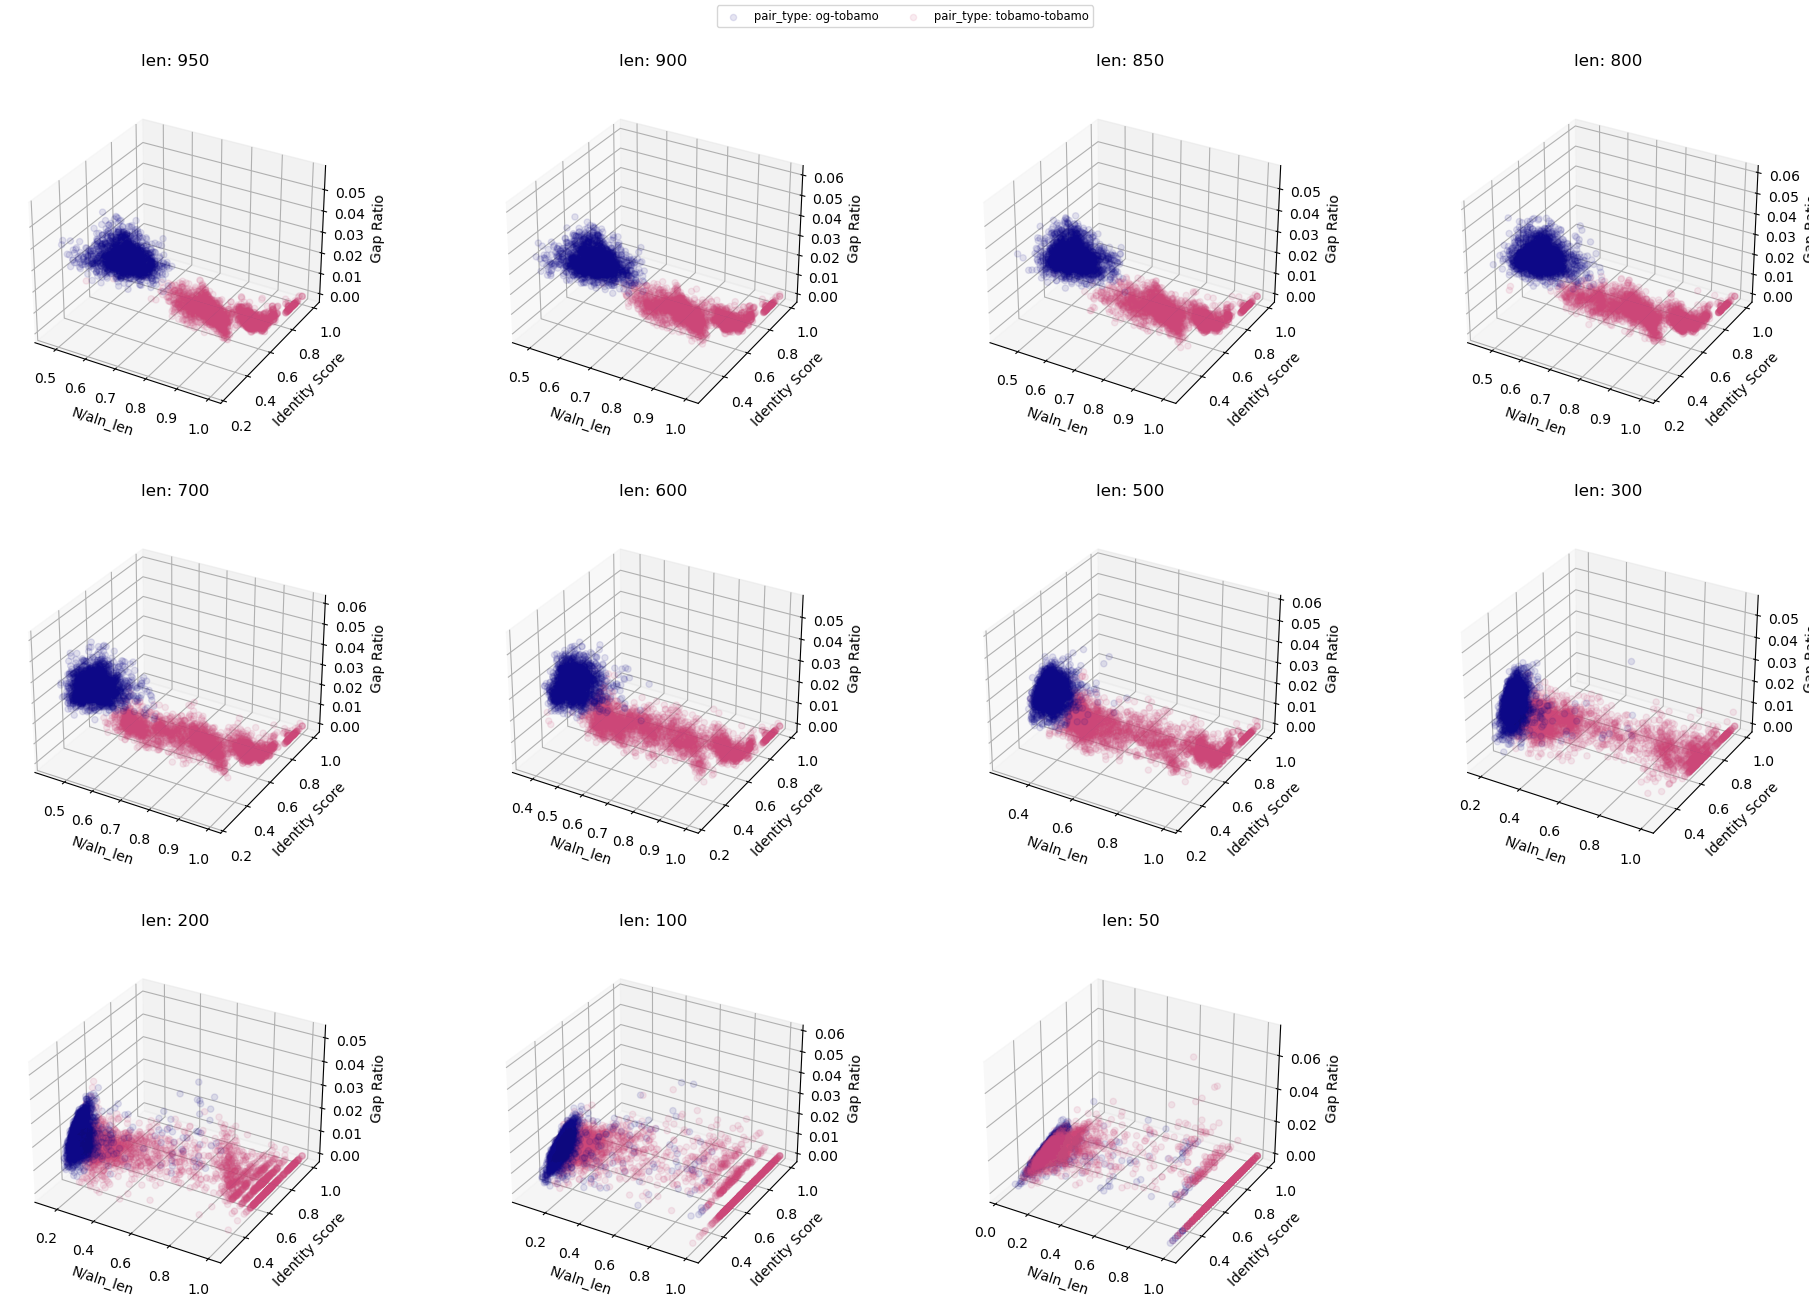

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Define a colormap
cmap = plt.get_cmap('plasma')
unique_pair_types = sub_df['pair_type'].unique()
sorted_lens = np.sort(sub_df['len'].unique())[::-1]  # Sort by descending len
colors = {pair_type: cmap(i / len(unique_pair_types)) for i, pair_type in enumerate(unique_pair_types)}

# Determine the grid size for subplots
num_plots = len(sorted_lens)
grid_size = int(np.ceil(np.sqrt(num_plots)))

fig = plt.figure(figsize=(20, 18))

# Plot the scatter plots
for idx, u_len in enumerate(sorted_lens):
    ax = fig.add_subplot(grid_size, grid_size, idx + 1, projection='3d')
    
    for pair_type in unique_pair_types:
        subset = sub_df[(sub_df['pair_type'] == pair_type) & (sub_df['len'] == u_len)]
        ax.scatter(subset['N/aln_len'], subset['identity_score'], subset['gap_ratio'],
                   color=colors[pair_type], alpha=0.1, label=f'pair_type: {pair_type}')
    
    # Labels and title
    ax.set_xlabel('N/aln_len')
    ax.set_ylabel('Identity Score')
    ax.set_zlabel('Gap Ratio')
    ax.set_title(f'len: {u_len}', pad=20)

# Create a single legend for the entire figure
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), loc='upper center', fontsize='small', ncol=2)

plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.3, hspace=0.3)
# plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

SCV - Support Vector Classification

In [36]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [37]:
data = sub_df[['identity_score', 'gap_ratio', 'N/aln_len', 'pair_type', 'len']].reset_index(drop=True)

X = data[['identity_score', 'gap_ratio', 'N/aln_len', 'len']]
y = (data['pair_type'] == 'tobamo-tobamo').astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [38]:
model = SVC(kernel='linear', C=0.1)
model.fit(X_train, y_train)

SVC(C=0.1, kernel='linear')

In [39]:
# Return the mean accuracy on the given test data and labels.
model.score(X_test, y_test)

0.9493059746529873

In [47]:
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from mlxtend.plotting import plot_decision_regions

In [69]:
svm = SVC(C=0.5, kernel='rbf')
svm.fit(X_train[:2000,:2], y_train[:2000])

SVC(C=0.5)

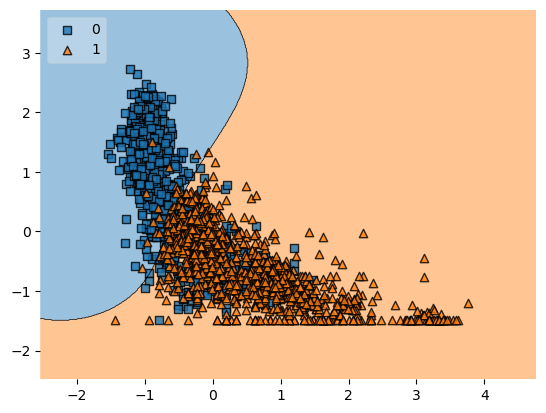

In [70]:
plot_decision_regions(X_train[:2000,:2], y_train[:2000].values, clf=svm, legend=2)
plt.show()

In [67]:
svm = SVC(C=0.5, kernel='rbf')
svm.fit(X_train[:2000,1:3], y_train[:2000])

SVC(C=0.5)

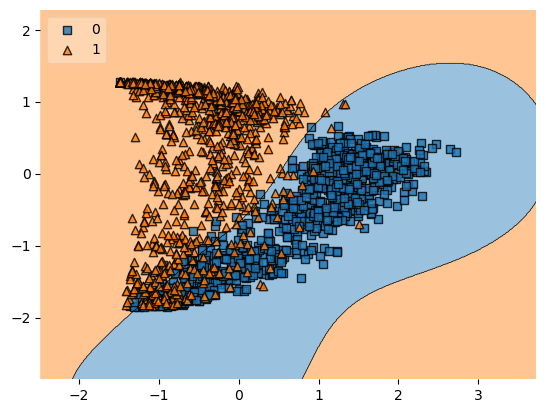

In [68]:
plot_decision_regions(X_train[:2000,1:3], y_train[:2000].values, clf=svm, legend=2)
plt.show()

In [65]:
svm = SVC(C=0.5, kernel='linear')
svm.fit(X_train[:2000,2:4], y_train[:2000])

SVC(C=0.5, kernel='linear')

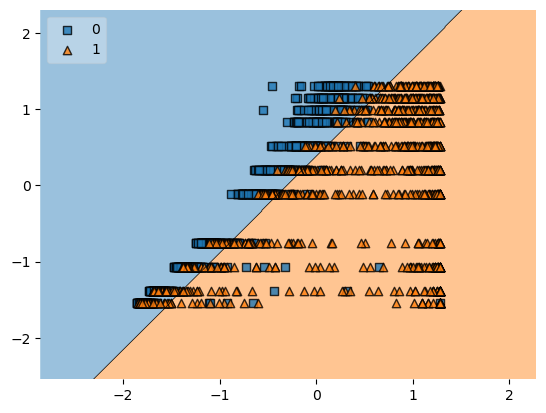

In [66]:
plot_decision_regions(X_train[:2000,2:4], y_train[:2000].values, clf=svm, legend=2)
plt.show()